In [3]:
import sys
print(sys.version)

3.12.3 (main, Sep 11 2024, 14:17:37) [GCC 13.2.0]


In [18]:
#
# Load and extract the 327k bucket names downloaded from Grayhat Warfare
#
# The provided S3 names contain complete AWS domain information as well, which will be one of the following formats:
# 1) [bucket_name].s3.amazonaws.com
# 2) [bucket_name].s3-[aws_region].amazonaws.com
# 3) [bucket_name].s3.[aws_region].amazonaws.com
# 
#
import json, re

def extract_bucket_name(bucket_url):
    # Define regex pattern to match and capture the bucket name
    pattern = r"^(.+)?\.s3(?:[\.-])(.+)?amazonaws.com(?:\.[a-z]{2})?$"
    
    # Search for the pattern in the given URL
    match = re.match(pattern, bucket_url)
    
    # Return the bucket name if found, otherwise None
    return match.group(1) if match else None


with open('buckets.json', 'r') as f:
    gh_data = json.load(f)

bucket_names = [x['bucket'] for x in gh_data]
bucket_names = [extract_bucket_name(x) for x in bucket_names]
bucket_names = [b for b in bucket_names if b is not None]

# Save point, all bucket names minus the AWS domains
with open('parsed_buckets.json', 'w') as f:
    json.dump(bucket_names, f, indent=2)

In [27]:
#
# Let's attempt to tokenize
#
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

##
## Due to weird behavior, I ended up downloading *all* corpora and models to get the
## punkt tokenizer operational.
##
#nltk.download()

import json

with open('parsed_buckets.json') as f:
    buckets = json.load(f)

# Start with a simple Regex based tokenizer for the light work.
custom_tokenizer = RegexpTokenizer(r'\d+|[a-zA-Z]+')
tokenized_buckets = []
for b in buckets:
   tokenized_buckets.append(custom_tokenizer.tokenize(b.lower()))

from wordsegment import load, segment
load()
results = []
for bucket in tokenized_buckets:
    current_tokens = []
    for b in bucket:
       current_tokens.extend(segment(b))
    results.append(current_tokens)

#
# Lemmatize the tokens prior to saving.
#
lemmatized_results = []
import spacy
nlp = spacy.load("en_core_web_sm")
for token_list in results:
    lemmatized_results.append([nlp(word)[0].lemma_ for word in token_list])

with open("tokenized_buckets.json", "w") as f:
    json.dump(lemmatized_results, f, indent=2)

In [40]:
#
# Tag all bucket tokens with parts of speech with NLTK
# 
from nltk.corpus import brown
from nltk.tag import UnigramTagger, RegexpTagger


def build_base_tagger(backoff_tagger):
    # Load tagged sentences from different categories in the Brown corpus
    train_data_news = brown.tagged_sents(categories='news')
    train_data_fiction = brown.tagged_sents(categories='fiction')
    train_data_hobbies = brown.tagged_sents(categories='hobbies')
    train_data_government = brown.tagged_sents(categories='government')

    # Create UnigramTaggers with backoffs in sequence to broaden coverage
    # Start with the most domain-specific tagger and chain others as backoffs
    government_tagger = UnigramTagger(train_data_government, backoff=backoff_tagger)  # Lowest priority tagger
    hobbies_tagger = UnigramTagger(train_data_hobbies, backoff=government_tagger)
    fiction_tagger = UnigramTagger(train_data_fiction, backoff=hobbies_tagger)
    return UnigramTagger(train_data_news, backoff=fiction_tagger)  # Primary tagger    
    
with open("country_codes.json", 'r') as f:
    ccs = json.load(f)
CC = list(ccs.keys())


custom_terms = []

with open("custom_tags.json", "r") as f:
    custom_tags = json.load(f)
    for key, tag_list in custom_tags.items():
        custom_terms.extend([(item, key) for item in tag_list])

custom_terms.extend([(key.lower(), 'CC_TLD') for key in CC])
custom_terms = [custom_terms]

# Regex tagging for various items
patterns = [
    (r'^20(0[0-9]|1[0-9]|2[0-5])$', 'YEAR'),
    (r'^[\d+]$', 'CD'), # Digits
    (r'^[a-z]{2}$', '2ALPHA'),# 2 Alphabet characters
    (r'^[a-z]$', 'ALPHA'),    # Alphabet character

]

# Create the RegexpTagger
regex_tagger = RegexpTagger(patterns)
base_tagger = build_base_tagger(regex_tagger)
tagger = UnigramTagger(custom_terms, backoff=base_tagger)

with open("tokenized_buckets.json", "r") as f:
    buckets = json.load(f)


tagged_buckets = [tagger.tag(bucket) for bucket in buckets]

with open("tagged_buckets.json", "w") as f:
    json.dump(tagged_buckets, f, indent=2)


In [ ]:
import json

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

untagged_counts = {}
for bucket in tagged_buckets:
    for tag_pair in bucket:
        txt = tag_pair[0]
        tag = tag_pair[1]

        if tag == None:
            count = untagged_counts.get(txt, 0)
            count = count + 1
            untagged_counts[txt] = count
sorted_untagged_counts = dict(sorted(untagged_counts.items(), key=lambda item: item[1], reverse=True))

with open("untagged_tokens.json", "w") as f:
    json.dump(sorted_untagged_counts, f, indent=2)
    
    

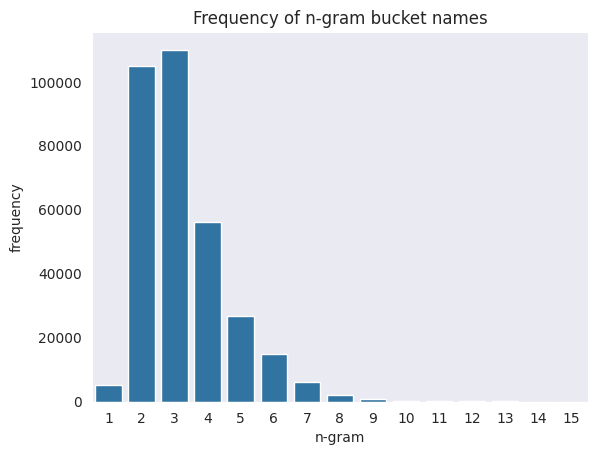

In [42]:
#
# Let's get some statistics on the n-gram tokens
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

n_grams = {}

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

for bucket_tags in tagged_buckets:
    tag_len = len(bucket_tags)
    count = n_grams.get(tag_len, 0)
    count = count + 1
    n_grams[tag_len] = count


#
# To prevent the long-tail from clogging up our view, filter out any n-grams with
# less than 50 count (out of 327,000)
#
filtered_n_grams = {key: value for key, value in n_grams.items() if value >= 50}

# Convert dictionary to DataFrame
df = pd.DataFrame(list(filtered_n_grams.items()), columns=["Key", "Value"])

# Sort the DataFrame by "Key" to match ascending key order
df = df.sort_values(by="Key")


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to normalize all values in the DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Plot the frequency with Seaborn
sns.set_style("dark")
sns.barplot(x="Key", y="Value", data=df)
plt.title("Frequency of n-gram bucket names")
plt.xlabel("n-gram")
plt.ylabel("frequency")
plt.show()




In [78]:
import json

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

#
# Given a list of tokenized and tagged buckets, return a map of transition counts between
# the tag types
#
# Keys are compund and of the form '<src>-<dst>'
#
def build_transition_counts(buckets) -> dict:
    transition_counts = {}

    ignored = 0
    for bucket in buckets:
        blen = len(bucket)
        counts_map = transition_counts.get(blen, {})
        if blen == 1:
            ignored = ignored +1
            continue # We can't operate on a unigram bucket name
        # Each bucket is a list(list(txt, tag)) , We only care about the tag and the following tag.
        src_tag = None
        for pair in bucket:
            tag = pair[1]
            if src_tag == None:
                # This is our first time through, save the tag and continue
                src_tag = tag
                continue
            else:
                # Mark the transition
                key = f"{src_tag}/{tag}"
                count = counts_map.get(key, 0)
                count = count + 1
                counts_map[key] = count
                src_tag = tag
        transition_counts[blen] = counts_map
    print(f"Ignored {ignored} unigram buckets")
    return transition_counts

counts = build_transition_counts(tagged_buckets)
for key, transition_map in counts.items():
    sorted_counts = {key: value for key, value in sorted(transition_map.items(), key=lambda item: item[1], reverse=True)}
    print(f"[{key}]: {sorted_counts}")
# sum = 0
# for key, value in counts.items():
#     sum = sum + value
# print(f"{sum} total transitions")
# print(sorted_counts)


Ignored 965 unigram buckets
[2]: {'NNP/NNP': 744, 'NN/NN': 725, 'NNP/INFRA': 432, 'NNP/NN': 395, 'JJ/NN': 296, 'NNP/PHASE': 202, 'NN/INFRA': 199, 'VB/NN': 144, 'INFRA/NN': 122, 'NN/PHASE': 96, 'NNP/CD': 79, 'NNP/WEB': 78, 'NN/CD': 75, 'PHASE/NN': 75, 'NN/WEB': 59, 'CD/NN': 58, 'VB/INFRA': 56, 'PRP/VBP': 50, 'WEB/NN': 48, 'INFRA/NNP': 46, 'JJ/INFRA': 44, 'INFRA/INFRA': 42, 'DT/NN': 42, 'NNP/TLD': 39, 'LS/NN': 38, 'PHASE/NNP': 36, 'JJ/PHASE': 36, 'IN/NN': 35, 'NNP/VBP': 34, 'INFRA/CD': 32, 'VB/PRP': 32, 'NNP/VB': 30, 'UH/NN': 28, 'NNP/PRP': 27, 'NN/JJ': 27, 'VBP/NN': 27, 'NN/NNP': 27, 'VB/CD': 26, 'PHASE/CD': 24, 'PRP$/NN': 24, 'VB/JJ': 23, 'NN/PRP': 22, 'VB/DT': 22, 'FW/NN': 21, 'VB/RB': 21, 'NN/VBP': 21, 'NNP/DT': 20, 'UH/INFRA': 19, 'VB/NNP': 19, 'VB/PHASE': 18, 'NNP/FW': 18, 'NN/VB': 18, 'NNP/JJ': 17, 'NN/IN': 17, 'NNP/IN': 17, 'WEB/INFRA': 16, 'NN/RB': 16, 'XX/NN': 15, 'FW/INFRA': 15, 'NNP/DEV': 15, 'NN/TLD': 14, 'CD/INFRA': 13, 'WEB/CD': 13, 'VB/WEB': 13, 'VB/IN': 13, 'IN/INFRA': 1

In [79]:
#
# Let's figure out how many unique tags we have here
#
import json

with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

tags = set()

for bucket in tagged_buckets:
    for tag_tuple in bucket:
        tags.add(tag_tuple[1])

print(len(tags))
print(tags)

48
{'WP', 'CC', 'RBS', 'NNS', 'VBD', 'PHASE', 'JJS', 'LS', 'ADD', 'VBZ', 'UH', 'RB', 'NFP', 'CD', 'TLD', 'IN', 'DEV', 'NNPS', '.', 'PRP', 'FW', 'WDT', 'XX', 'INFRA', 'PDT', 'POS', '``', 'DT', "''", 'VB', 'NNP', 'TO', 'WEB', 'JJ', 'EX', 'PRP$', 'VBG', 'SYM', 'RBR', 'WRB', 'RP', '-RRB-', 'VBN', 'NN', 'AFX', 'JJR', 'MD', 'VBP'}


In [80]:
#
# Lets take a look at the None tags
#
with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

none_tags = {}

for bucket in tagged_buckets:
    for tag_tuple in bucket:
        txt = tag_tuple[0]
        if tag_tuple[1] is None:
            count = none_tags.get(txt, 0)
            count += 1
            none_tags[txt] = count

sorted_counts = {key: value for key, value in sorted(none_tags.items(), key=lambda item: item[1], reverse=True)}
print(sorted_counts)

{}


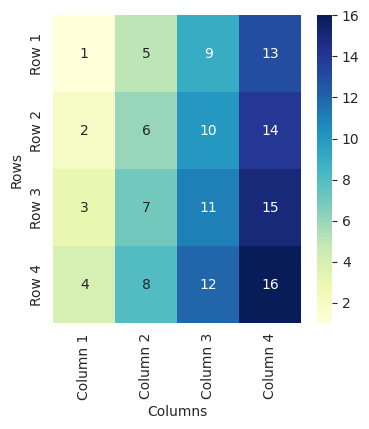

In [85]:
import pandas as pd

# Creating a 4x4 matrix
data = {
    'Column 1': [1, 2, 3, 4],
    'Column 2': [5, 6, 7, 8],
    'Column 3': [9, 10, 11, 12],
    'Column 4': [13, 14, 15, 16]
}
df = pd.DataFrame(data)

# Naming the row and column indexes
df.index = ['Row 1', 'Row 2', 'Row 3', 'Row 4']
df.index.name = 'Rows'
df.columns.name = 'Columns'

df

import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
plt.figure(figsize=(4, 4))  # Adjust size if needed
sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=True)

# Display the heatmap
plt.show()

In [10]:
import stanza

stanza.download('en')  # Download English models
nlp = stanza.Pipeline('en', processors='tokenize,ner')
doc = nlp("Barack Obama was born in Hawaii.")
for ent in doc.entities:
    print(ent.text, ent.type)


/home/jason/rowan/cs02625/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-22 08:59:09 INFO: Downloaded file to /home/jason/stanza_resources/resources.json
2024-11-22 08:59:09 INFO: Downloading default packages for language: en (English) ...
2024-11-22 08:59:25 INFO: Downloaded file to /home/jason/stanza_resources/en/default.zip
2024-11-22 08:59:32 INFO: Finished downloading models and saved to /home/jason/stanza_resources
2024-11-22 08:59:32 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-11-22 08:59:32 INFO: Downloaded file to /home/jason/stanza_resources/resources.json
2024-11-22 08:59:32 WARNING: Language en package default expect

Barack Obama PERSON
Hawaii GPE


In [ ]:
#
# Modifying and (hopefully) simplifying our pipeline with Spacy.  We still need to tokenize as usual, let's 
# do that now.
#
import json

with open('parsed_buckets.json') as f:
    buckets = json.load(f)

# Start with a simple Regex based tokenizer for the light work.
custom_tokenizer = RegexpTokenizer(r'\d+|[a-zA-Z]+')
tokenized_buckets = []
for b in buckets:
   tokenized_buckets.append(custom_tokenizer.tokenize(b.lower()))

from wordsegment import load, segment
load()
results = []
for bucket in tokenized_buckets:
    current_tokens = []
    for b in bucket:
       current_tokens.extend(segment(b))
    results.append(current_tokens)

In [ ]:
#
# Set up the Spacy pipeline
#
import spacy
from spacy.tokens import Token, Span
from spacy.language import Language

# Load the spaCy pipeline
nlp = spacy.load("en_core_web_md")

# Add custom attributes
Token.set_extension("is_custom_tagged", default=False, force=True)
Token.set_extension("custom_tag", default=None, force=True)

# Define a custom tagging component
@Language.component("custom_tagger")
def custom_tagger(doc):
    custom_tags = {}
    with open('custom_tags.json', 'r') as f:
        custom_tag_src = json.load(f)
        for tag, words in custom_tag_src.items():
            for word in words:
                custom_tags[word] = tag

    # custom_words = {
    #     "AI": "TECH",
    #     "Google": "CORPORATION",
    #     "spaCy": "TOOL",
    # }

    for token in doc:
        if token.text in custom_tags:
            t = custom_tags[token.text]
            # print(f"Tagging {token.text} as {t}")
            token._.is_custom_tagged = True
            token._.custom_tag = t
            token.ent_type_ = t
            token.tag_ = t
    return doc

# Add the custom tagger to the pipeline
nlp.add_pipe("custom_tagger", after="ner")
# nlp.remove_pipe("tagger")
print("Pipeline Component Order:", nlp.pipe_names)

bucket_names = []
with open('tokenized_buckets.json', 'r') as f:
    tokenized_buckets = json.load(f)
    bucket_names.extend([" ".join(b) for b in tokenized_buckets])

with open('tagged_buckets.json', 'w') as f:
    all_tags = []
    for bucket_name in bucket_names:
        doc = nlp(bucket_name)
        # print("Token Details:")
        tags = []
        for token in doc:
            tags.append((str(token.lemma_), str(token.tag_)))
            # print(f"Text: {token.text}, Lemma: {token.lemma_}, POS: {token.pos_}, Custom Tag: {token._.custom_tag}")
        all_tags.append(tags)

    json.dump(all_tags, f, indent=2)
# # Process text
# doc = nlp("Google and spaCy are advancing AI technologies in Mountain View.")

# # Results
# print("Token Details:")
# for token in doc:
#     print(f"Text: {token.text}, Lemma: {token.lemma_}, POS: {token.pos_}, Custom Tag: {token._.custom_tag}")


Pipeline Component Order: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'custom_tagger']


In [ ]:
    # "CITY": ["chicago", "houston", "nyc", "dallas", "vegas", "phoenix", "london", "atlanta", "denver", "orlando", "tokyo", "seattle", "sydney", "charlotte", 
    # "boston", "brooklyn", "columbus", "portland", "philadelphia", "singapore"],
    # "ST_ABBREV": ["tx", "fl", "ny", "wa", "oh", "nj", "dc", "ct", "ut", "ks", "ak", "nv", "nd", "nh"]    